In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../src")

In [2]:
import os
import json
import numpy as np
import itertools
import matplotlib.pyplot as plt

from tqdm import tqdm

from pathlib import Path
from filter_parser import Rule

## Data acquisition

In [3]:
DATA_ROOT_DIR = Path("/tmp/easylist_processed")
easylist_dir = DATA_ROOT_DIR / "all_easylists"
diff_dir = DATA_ROOT_DIR / "easylists_diff"
easylist_dir_filenames = os.listdir(easylist_dir)
diff_dir_filenames = os.listdir(diff_dir)
easylist_dir_filenames.sort()
diff_dir_filenames.sort()

In [4]:
def dict_from_diff_file(diff_filepath):
    diff_filepath = Path(diff_filepath)
    assert diff_filepath.exists() and diff_filepath.is_file()
    with diff_filepath.open("r", encoding="utf-8") as fp:
        d = json.load(fp)

    def _transform(rule_dict):
        return Rule(**rule_dict)

    return {
        "added": [_transform(r) for r in d["added"]],
        "deleted": [_transform(r) for r in d["deleted"]],
    }

In [5]:
dict_from_diff_file(diff_dir / "00000_00001.json")

{'added': [Rule(raw_rule_text='||copyfuture.com/images/zhifubao.jpg', domain='copyfuture.com', is_exception=False, is_html_rule=False, options={})],
 'deleted': []}

In [6]:
diff_dir_json_list = os.listdir(diff_dir)
diff_dir_json_list.sort()
diff_dict = {json_name: dict_from_diff_file(diff_dir / json_name) for json_name in diff_dir_json_list}

In [7]:
next(iter(diff_dict.items()))

('00000_00001.json',
 {'added': [Rule(raw_rule_text='||copyfuture.com/images/zhifubao.jpg', domain='copyfuture.com', is_exception=False, is_html_rule=False, options={})],
  'deleted': []})

## Utilities

In [8]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def find_easylist_filename_by_idx(idx) -> str:
    idx = int(idx)
    return easylist_dir_filenames[idx]

def get_commit_time_diff_by_idx(new_idx, old_idx) -> int:
    """
    Compute the time difference between two commit identified by its index in `easylist_dir`.

    Args:
        new_idx: newer commit idx, should be less than `old_idx`
        old_idx: older commit idx, should be greater than `new_idx`

    Returns:
        time difference in seconds
    """
    new_idx = int(new_idx)
    old_idx = int(old_idx)
    assert new_idx <= old_idx
    new_filename = find_easylist_filename_by_idx(new_idx)
    old_filename = find_easylist_filename_by_idx(old_idx)
    new_ts = int(new_filename[:-4].split("_")[2])
    old_ts = int(old_filename[:-4].split("_")[2])
    return new_ts - old_ts


## Experiments

### Commit average time cost

In [9]:
filename_list = os.listdir(easylist_dir)
filename_list.sort()

In [10]:
# record time cost in seconds
commit_avg_time_cost_list = list()
smallest_new_ts = sys.maxsize
for new, old in pairwise(filename_list):
    new_ts = int(new[:-4].split("_")[2])
    old_ts = int(old[:-4].split("_")[2])
    if smallest_new_ts >= new_ts >= old_ts:
        commit_avg_time_cost_list.append(new_ts - old_ts)
    smallest_new_ts = min(smallest_new_ts, new_ts)
commit_avg_time_cost_list = np.array(commit_avg_time_cost_list)

(array([2.2518e+04, 7.5250e+03, 2.1550e+03, 1.2540e+03, 8.2800e+02,
        6.1400e+02, 5.0900e+02, 4.2300e+02, 4.5900e+02, 5.1800e+02,
        4.9400e+02, 5.4500e+02, 4.4800e+02, 3.7500e+02, 2.8600e+02,
        2.0900e+02, 1.6400e+02, 1.0000e+02, 7.1000e+01, 4.7000e+01,
        3.0000e+01, 2.7000e+01, 1.9000e+01, 2.7000e+01, 3.7000e+01,
        2.0000e+01, 1.9000e+01, 2.7000e+01, 3.0000e+01, 1.2000e+01]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

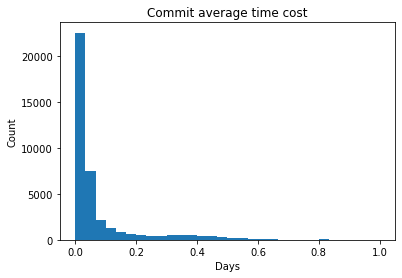

In [11]:
SECONDS_PER_DAY = 3600 * 24
_, ax = plt.subplots(1, 1)
ax.set_title("Commit average time cost")
ax.set_xlabel("Days")
ax.set_ylabel("Count")
ax.hist(commit_avg_time_cost_list / SECONDS_PER_DAY, bins=30, range=(0, 1))

(array([0.56592109, 0.75503895, 0.80919829, 0.84071375, 0.861523  ,
        0.87695401, 0.88974617, 0.90037698, 0.91191254, 0.92493089,
        0.93734607, 0.95104298, 0.96230209, 0.97172656, 0.9789143 ,
        0.98416688, 0.98828851, 0.99080171, 0.99258608, 0.99376728,
        0.99452124, 0.9951998 , 0.99567731, 0.99635587, 0.99728575,
        0.99778839, 0.9982659 , 0.99894446, 0.99969842, 1.        ]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

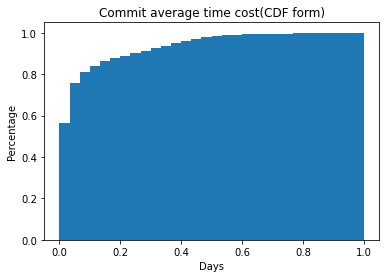

In [12]:
_, ax = plt.subplots(1, 1)
ax.set_title("Commit average time cost(CDF form)")
ax.set_xlabel("Days")
ax.set_ylabel("Percentage")
ax.hist(commit_avg_time_cost_list / SECONDS_PER_DAY, bins=30, range=(0, 1), cumulative=True, density=True)

### FP statistics
Simply count all "exception rules" in `added` part of `diff_dict`.

In [13]:
fp_count = 0
fp_solved_list = list()
for diff_key, diff in diff_dict.items():
    new_idx, _ = diff_key[:-5].split("_")
    for added_rule in diff["added"]:
        added_rule: Rule
        if not added_rule.is_exception:
            continue
        for added_other_rule in diff["added"]:
            added_other_rule: Rule
            if added_rule.domain == added_other_rule.domain \
                and added_rule.is_exception != added_other_rule.is_exception \
                and added_rule.is_html_rule == added_other_rule.is_html_rule:
                break
        else:
            # real fp errors will go here
            fp_count += 1 if added_rule.is_exception else 0
            fp_solved_list.append((new_idx, added_rule))


In [14]:
fp_count

2791

In [15]:
fp_solved_list[0]

('00007',
 Rule(raw_rule_text='@@||pagead2.googlesyndication.com/pagead/js/adsbygoogle.js$domain=mpyit.com|chaojizhibo.net|chtoen.com|daxiaamu.com|dizhishengcheng.com|doitwell.tw|eu4cn.com|ff14angler.com|freedidi.com|haoweichi.com|it365.abctool.info|linovelib.com|logi.im|monnsutogatya.com|numberempire.com|ozabc.com|patch.ali213.net|pc3mag.com|shenfendaquan.com|sto520.com|switch520.com|vaptcha.com|wenxuecity.com|wuyong.fun|xbeibeix.com|xiebruce.top|xugaoxiang.com|xxxxx520.com|yodu.org', domain='pagead2.googlesyndication.com', is_exception=True, is_html_rule=False, options={'domain': {'mpyit.com': True, 'chaojizhibo.net': True, 'chtoen.com': True, 'daxiaamu.com': True, 'dizhishengcheng.com': True, 'doitwell.tw': True, 'eu4cn.com': True, 'ff14angler.com': True, 'freedidi.com': True, 'haoweichi.com': True, 'it365.abctool.info': True, 'linovelib.com': True, 'logi.im': True, 'monnsutogatya.com': True, 'numberempire.com': True, 'ozabc.com': True, 'patch.ali213.net': True, 'pc3mag.com': True, 

### Frequency of changes of second level domain(SLD)

In [16]:
pass

### Interval between standalone exception rule and its nearest occurrence


In [17]:
fp_time_costs = list()
for fp_idx, fp_rule in tqdm(fp_solved_list):
    fp_rule: Rule
    for old_idx in range(int(fp_idx) + 1, len(diff_dict)):
        # find the nearest commit that added some related rule
        old_diff = diff_dict[f"{int(old_idx):05}_{int(old_idx) + 1:05}.json"]
        for old_added in old_diff["added"]:
            old_added: Rule
            if fp_rule.domain == old_added.domain and fp_rule.is_html_rule == old_added.is_html_rule:
                # once found, break
                fp_time_costs.append(abs(get_commit_time_diff_by_idx(fp_idx, old_idx)))
                break
        break

# transform secs to days
fp_time_costs = np.array(fp_time_costs) / 3600 / 24


100%|██████████| 2791/2791 [00:00<00:00, 513074.27it/s]


In [18]:
np.mean(fp_time_costs)

974.369356717386

In [19]:
np.std(fp_time_costs)

745.4183252149834

(array([16., 12., 13.,  7.,  7.,  5., 13.,  6.,  7.,  1., 15.,  4.,  4.,
         9.,  3.,  4.,  2.,  5.,  1.,  7.,  3.,  3.,  0.,  1.,  2.,  1.,
         1.,  1.,  1.,  3.]),
 array([  36.52616898,  135.19029784,  233.8544267 ,  332.51855556,
         431.18268441,  529.84681327,  628.51094213,  727.17507099,
         825.83919985,  924.5033287 , 1023.16745756, 1121.83158642,
        1220.49571528, 1319.15984414, 1417.82397299, 1516.48810185,
        1615.15223071, 1713.81635957, 1812.48048843, 1911.14461728,
        2009.80874614, 2108.472875  , 2207.13700386, 2305.80113272,
        2404.46526157, 2503.12939043, 2601.79351929, 2700.45764815,
        2799.12177701, 2897.78590586, 2996.45003472]),
 <BarContainer object of 30 artists>)

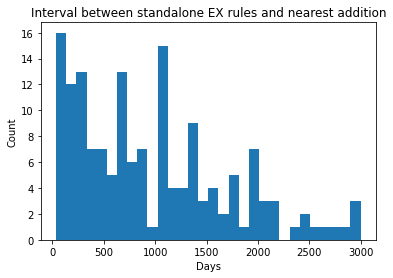

In [20]:
_, ax = plt.subplots(1, 1)
ax.set_title("Interval between standalone EX rules and nearest addition")
ax.set_xlabel("Days")
ax.set_ylabel("Count")
ax.hist(fp_time_costs, bins=30)

(array([0.10191083, 0.17834395, 0.2611465 , 0.30573248, 0.35031847,
        0.38216561, 0.46496815, 0.50318471, 0.5477707 , 0.55414013,
        0.64968153, 0.67515924, 0.70063694, 0.75796178, 0.77707006,
        0.80254777, 0.81528662, 0.84713376, 0.85350318, 0.89808917,
        0.91719745, 0.93630573, 0.93630573, 0.94267516, 0.95541401,
        0.96178344, 0.96815287, 0.97452229, 0.98089172, 1.        ]),
 array([  36.52616898,  135.19029784,  233.8544267 ,  332.51855556,
         431.18268441,  529.84681327,  628.51094213,  727.17507099,
         825.83919985,  924.5033287 , 1023.16745756, 1121.83158642,
        1220.49571528, 1319.15984414, 1417.82397299, 1516.48810185,
        1615.15223071, 1713.81635957, 1812.48048843, 1911.14461728,
        2009.80874614, 2108.472875  , 2207.13700386, 2305.80113272,
        2404.46526157, 2503.12939043, 2601.79351929, 2700.45764815,
        2799.12177701, 2897.78590586, 2996.45003472]),
 <BarContainer object of 30 artists>)

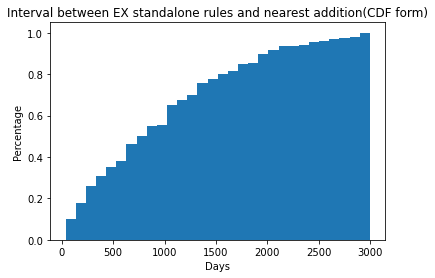

In [21]:
_, ax = plt.subplots(1, 1)
ax.set_title("Interval between EX standalone rules and nearest addition(CDF form)")
ax.set_xlabel("Days")
ax.set_ylabel("Percentage")
ax.hist(fp_time_costs, bins=30, cumulative=True, density=True)